# Michel Electron Selection and Reconstruction

Michel electrons come out of a muon decay. They are electrons, so they look like a lower energy electromagnetic shower attached to the end of a stopping muon track.

### Requirements:
 * U-ResNet for Semantic Segmentation
 * DBSCAN for Michel/shower fragment clustering
 * GrapPA-Shower for Michel primary/shower secondaries aggregation

## I. Motivation

Michel electrons are used in LArTPC experiments as “standard candles”: we understand their energy spectrum very well, so they can be used to calibrate the detector and to compare the quality of different detectors. The Michel electron spectrum is one of the first “tokens” that an experiment will show to prove that the detector is running and we can successfully reconstruct the data. Since their energy is in a range up to ~50MeV, they are also representative of the detector response to electromagnetic particles generated by low energy neutrino activity.

<figure>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQsezzzPeMfyra-aaqqooRh-IAVN61XbgDDuQ&usqp=CAU" style="width:50%">
<figcaption align = "center"> Example of Michel electron spectrum </figcaption>
</figure>


### What are we looking for?

The primary Michel electron that comes out of the muon decay-at-rest can lose energy either through ionization (collision stopping power), or through the production of radiative photons via Bremsstrahlung (radiative stopping power). Beyond a certain energy, the radiative stopping power is greater than the collision stopping power. If the radiative photons have enough energy, they can pair-produce, i.e. turn into an electron-positron pair. They, in turn, can produce new radiative photons, and so on. They can also undergo Compton scattering. A cascade of electrons and photons (electromagnetic shower) happens.

<figure>
<img src="electron_stopping_power.png" style="width:50%">
<figcaption align = "center"> Energy loss per unit distance (MeV/cm) for electrons traveling in liquid argon </figcaption>
</figure>

Ionization produces track-like energy depositions, whereas the photons can travel some distance before converting into a secondary electron. Hence Michel electrons have two clear topological features: a primary ionization, which is track-like at the end of the muon track, and some scattered energy deposits much further away which come from these radiative photons.

<figure>
<img src="michel.png" style="width:50%">
<figcaption align = "center"> Example of Michel electron topology </figcaption>
</figure>

## II. Setup

We first need to set the working environment and the path to the validation dataset.

In [32]:
import os, sys

SOFTWARE_DIR = '/sdf/group/neutrino/drielsma/lartpc_mlreco3d' # Change this path to your software install
DATA_DIR = '/sdf/group/neutrino/icarus/workshop2023/' # Change this path if you are not on SDF (see main README)

# Set software directory
sys.path.append(SOFTWARE_DIR)

### Imports
We will also need ``Plotly`` for visualization, ``NumPy``, ``Pandas`` and other libraries for convenience:

In [33]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re

# Visualization Tools
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns

### Load the output of the reconstruction chain

Let’s parse the analysis configuration file `anaconfig.cfg` to load the reconstruction output. This file uses the keyword `DATA_DIR` to symbolize the path to reconstructruted dataset. We need to replace it with the actual location defined previously.

In [34]:
# Load anatools config file
# Replace the source file with the correct path
DATA_PATH = DATA_DIR + 'reco/mpvmpr_mini_reco.h5'
anaconfig = '../../anaconfig.cfg' # Inside the main directory
anaconfig = yaml.safe_load(open(anaconfig, 'r').read().replace('DATA_PATH', DATA_PATH))

So far ``anaconfig`` was simply a dictionary loaded from a YAML configuration file. It needs to be consumed by a helper class, ``AnaToolsManager``, to be ready for the analysis usage:

In [35]:
# Initialize Anatools manager
from analysis.manager import AnaToolsManager

manager = AnaToolsManager(anaconfig)
manager.initialize()

Registered /sdf/group/neutrino/icarus/workshop2023/reco/mpvmpr_mini_reco.h5


We are now all set to load **one iteration** of the reconstruction output as follows:

In [36]:
# Get entry number #ENTRY_NUM from HDF5 (when reading from HDF5)
ENTRY_NUM = 3
data, result = manager.forward(iteration=ENTRY_NUM)

The input data and label information are loaded onto the `data` variable, while the outputs from the chain are stored inside `result`. We will use the output of this single iteration to demonstrate a simple Michel electron selection, before running with higher statistics (ie. performing many more iterations).

Now we load the true and reconstucted ``Particle`` objects:

In [37]:
manager.load_representations(data, result, mode='all')

particles = result['particles'][0]
truth_particles = result['truth_particles'][0]

These are simple lists of particles, so you could print them out to take a quick look:

In [38]:
particles

[Particle(image_id=3, id=0, pid=0, size=2438),
 Particle(image_id=3, id=1, pid=0, size=101),
 Particle(image_id=3, id=2, pid=1, size=5235),
 Particle(image_id=3, id=3, pid=0, size=1117),
 Particle(image_id=3, id=4, pid=0, size=446),
 Particle(image_id=3, id=5, pid=1, size=38),
 Particle(image_id=3, id=6, pid=1, size=17),
 Particle(image_id=3, id=7, pid=1, size=14),
 Particle(image_id=3, id=8, pid=1, size=99),
 Particle(image_id=3, id=9, pid=1, size=15),
 Particle(image_id=3, id=10, pid=1, size=5),
 Particle(image_id=3, id=11, pid=1, size=18),
 Particle(image_id=3, id=12, pid=1, size=37),
 Particle(image_id=3, id=13, pid=1, size=8),
 Particle(image_id=3, id=14, pid=1, size=23),
 Particle(image_id=3, id=15, pid=3, size=422),
 Particle(image_id=3, id=16, pid=2, size=338),
 Particle(image_id=3, id=17, pid=2, size=4300)]

In [39]:
truth_particles

[TruthParticle(image_id=3, id=0, pid=3, size=422),
 TruthParticle(image_id=3, id=1, pid=0, size=2572),
 TruthParticle(image_id=3, id=43, pid=1, size=38),
 TruthParticle(image_id=3, id=44, pid=0, size=93),
 TruthParticle(image_id=3, id=45, pid=0, size=3734),
 TruthParticle(image_id=3, id=88, pid=0, size=442),
 TruthParticle(image_id=3, id=89, pid=0, size=2474),
 TruthParticle(image_id=3, id=90, pid=2, size=4300),
 TruthParticle(image_id=3, id=91, pid=1, size=23),
 TruthParticle(image_id=3, id=92, pid=1, size=8),
 TruthParticle(image_id=3, id=93, pid=1, size=37),
 TruthParticle(image_id=3, id=94, pid=1, size=18),
 TruthParticle(image_id=3, id=95, pid=1, size=16),
 TruthParticle(image_id=3, id=96, pid=1, size=99),
 TruthParticle(image_id=3, id=139, pid=2, size=338),
 TruthParticle(image_id=3, id=145, pid=1, size=17),
 TruthParticle(image_id=3, id=146, pid=1, size=14),
 TruthParticle(image_id=3, id=150, pid=-1, size=10)]

We can also check the semantic type of each true and reconstucted particle. First, let's check what they mean:

In [40]:
from mlreco.utils.globals import SHAPE_LABELS

print(SHAPE_LABELS)

{0: 'Shower', 1: 'Track', 2: 'Michel', 3: 'Delta', 4: 'Low Energy', 5: 'Ghost', 6: 'Unknown'}


Now let's print them out, can you spot Michel electrons?

In [41]:
print([p.semantic_type for p in particles])
print([p.semantic_type for p in truth_particles])

[0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1]
[1, 0, 2, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0]


Let's count them:

In [42]:
from mlreco.utils.globals import MICHL_SHP

print('Number of reconstructed Michel:', np.sum(np.array([p.semantic_type for p in particles]) == MICHL_SHP))
print('Number of true Michel:', np.sum(np.array([p.semantic_type for p in truth_particles]) == MICHL_SHP))

Number of reconstructed Michel: 1
Number of true Michel: 1


## III. Selecting Michel Electrons

### Visualizing true and predicted particles

Let’s first import plotting functions from `lartpc_mlreco3d` for easier visualization:

In [43]:
from mlreco.visualization.points import get_event_displays
from mlreco.visualization.plotly_layouts import PLOTLY_COLORS_WGRAY, dualplot

We've seen before that we have a Michel electron among both true and predicted particles. Let's visualize both of these sets of particles: we create "traces" for Plotly with each set and plot the result.

In [44]:
from mlreco.visualization.plotly_layouts import PLOTLY_COLORS_WGRAY

traces_reco = get_event_displays(particles, color='semantic_type', size=1, mode='points', colorscale=PLOTLY_COLORS_WGRAY)
traces_true = get_event_displays(truth_particles, color='semantic_type', size=1, mode='points', colorscale=PLOTLY_COLORS_WGRAY)

The left plot shows predicted particles, the right plot shows true particles. The colors are arbitrary and represent the cluster id.

In [45]:
fig = dualplot(traces_reco, traces_true, titles=['Predicted particles (predicted no-ghost mask)', 'True particles (predicted no-ghost mask)'], synchronize=False, dark=True, detector_coords=True)
fig

Ok, so we can rotate the images around and confirm that there is one predicted and true Michel electron in this image.

### Selecting Michel candidates
**Criteria 1: is attached to muon**
To check if our candidate michel is actually adjacent to a track, we will set a minimum distance threshold (`attached_threshold`) between the Michel electron and the track.

> Wait, what if it was a misclassified Delta ray electron?

Delta ray electrons are knock off electrons that can happen along the trajectory of a muon, so if UResNet mispredicted the delta ray voxels as Michel voxels we would be wrong! To avoid that, let’s also make sure that the point of contact is at the end of the track.

**Criteria 2: is at the edge of muon**
Again, many ways to do this check, this is just one possible heuristic. We will do an *ablation* study: remove all muon voxels within a certain radius (`ablation_radius`) from the touching point, and compare the DBSCAN cluster count before and after ablation. DBSCAN needs two parameters to run (`ablation_eps` is a distance within which voxels get clustered together by DBSCAN, and `ablation_min_samples` is the minimal cluster voxel count). If the cluster count delta is $\leq 1$, we declare the test successful: the Michel electron is at the edge of the muon.

In [46]:
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

def is_attached_at_edge(points1, points2,
                        attached_threshold=1.5, # cm
                        ablation_eps=1.5, # cm
                        ablation_radius=4.5, # cm
                        ablation_min_samples=5):
    """
    Checks whether the cluster of coordinates points1
    is attached at the edge of the cluster points2.

    Parameters
    ==========
    points1: np.ndarray (M, 3)
    points2: np.ndarray (N, 3)

    Returns
    =======
    bool
    """
    #
    # Criteria 1: is it attached to the muon?
    #
    distances = cdist(points1, points2)
    is_attached = np.min(distances) < attached_threshold

    #
    # Criteria 2: is it at the edge of the muon?
    #

    # Find the touching point
    Michel_min, MIP_min = np.unravel_index(np.argmin(distances), distances.shape)
    min_coords = points2[MIP_min, :]
    
    # Define muon voxels after ablation
    ablated_cluster = points2[np.linalg.norm(points2-min_coords, axis=1) > ablation_radius]

    # Run DBSCAN before and after ablation
    new_cluster_count, old_cluster_count = 0, 1
    if ablated_cluster.shape[0] > 0:
        dbscan = DBSCAN(eps=ablation_eps, min_samples=ablation_min_samples)
        old_cluster = dbscan.fit(points2).labels_
        new_cluster = dbscan.fit(ablated_cluster).labels_
        # If only one cluster is left, we were at the edge
        # (accounts for case where a track is fragmented
        # and put together by Track GNN)
        is_edge = (old_cluster_count - new_cluster_count) <= 1 and old_cluster_count >= new_cluster_count
    else: # if nothing is left after ablating, this might be a really small muon... calling it the edge
        is_edge = True

    return is_attached and is_edge

**Selection = criteria 1 + criteria 2**

Now our actual selection code is very simple: pick predicted Michel particles and check whether they meet this criteria (attached at the edge of a predicted muon). Here is a good starting point for the parameters mentioned in the two criterias definition above:

In [47]:
attached_threshold = 3 # cm
ablation_eps = 3 # cm
ablation_radius = 4.5 # cm
ablation_min_samples = 5

In [48]:
from mlreco.utils.globals import TRACK_SHP, MICHL_SHP

def get_michels(particles):
    """
    Parameters
    ==========
    particles: list of Particle

    Returns
    =======
    list of Particle
    """
    selected_michels = []
    for p in particles:
        if p.semantic_type != MICHL_SHP: continue

        # Check whether it is attached to the edge of a track
        michel_is_attached_at_edge = False
        for p2 in particles:
            if p2.semantic_type != TRACK_SHP: continue
            if not is_attached_at_edge(p.points, p2.points,
                                    attached_threshold=attached_threshold,
                                    ablation_eps=ablation_eps,
                                    ablation_radius=ablation_radius,
                                    ablation_min_samples=ablation_min_samples): continue
            michel_is_attached_at_edge = True
            break

        # Require that the Michel is attached at the edge of a track
        if not michel_is_attached_at_edge: continue

        selected_michels.append(p)

    return selected_michels

We do successfully isolate the only Michel in this specific event:

In [49]:
selected_michels = get_michels(particles)
selected_michels

[Particle(image_id=3, id=5, pid=1, size=38)]

A good cross-check is to run the same selection on the true particles and confirm that it selects the known true Michel in this event

In [50]:
get_michels(truth_particles)

[TruthParticle(image_id=3, id=43, pid=1, size=38)]

### Matching with true Michel electrons

Although it seems pretty obvious in this specific event, we want to systematically match predicted and true Michel particles. We first have to match all particles with one another in the entire event. Earlier when I defined the predictor I have asked that two particles have at least 5 voxels overlap (`min_overlap`) with each other before a match can be declared.

In [51]:
from analysis.post_processing.evaluation.match import generate_match_pairs

matched_particles = generate_match_pairs(truth_particles, particles)
matched_particles = matched_particles['matches_r2t']

In [52]:
matched_particles

[(Particle(image_id=3, id=0, pid=0, size=2438),
  TruthParticle(image_id=3, id=89, pid=0, size=2474)),
 (Particle(image_id=3, id=1, pid=0, size=101),
  TruthParticle(image_id=3, id=44, pid=0, size=93)),
 (Particle(image_id=3, id=2, pid=1, size=5235),
  TruthParticle(image_id=3, id=45, pid=0, size=3734)),
 (Particle(image_id=3, id=3, pid=0, size=1117),
  TruthParticle(image_id=3, id=1, pid=0, size=2572)),
 (Particle(image_id=3, id=4, pid=0, size=446),
  TruthParticle(image_id=3, id=88, pid=0, size=442)),
 (Particle(image_id=3, id=5, pid=1, size=38),
  TruthParticle(image_id=3, id=43, pid=1, size=38)),
 (Particle(image_id=3, id=6, pid=1, size=17),
  TruthParticle(image_id=3, id=145, pid=1, size=17)),
 (Particle(image_id=3, id=7, pid=1, size=14),
  TruthParticle(image_id=3, id=146, pid=1, size=14)),
 (Particle(image_id=3, id=8, pid=1, size=99),
  TruthParticle(image_id=3, id=96, pid=1, size=99)),
 (Particle(image_id=3, id=9, pid=1, size=15),
  TruthParticle(image_id=3, id=95, pid=1, size=

Now we will loop over previously selected Michel candidates and record voxel count and voxel sum for both the predicted Michel and its matched true Michel:

In [53]:
def fill_dataframe(selected_michels, matched_particles):

    michels = {
        "pred_num_pix": [],
        "pred_sum_pix": [],
        "true_num_pix": [],
        "true_sum_pix": [],
        "true_noghost_primary_num_pix": [],
        "true_noghost_primary_sum_pix": []
    }

    for p in selected_michels:
        michels["pred_num_pix"].append(p.size)
        michels["pred_sum_pix"].append(p.depositions.sum())

        michels["true_num_pix"].append(-1)
        michels["true_sum_pix"].append(-1)
        michels["true_noghost_primary_num_pix"].append(-1)
        michels["true_noghost_primary_sum_pix"].append(-1)
        
        for mp in matched_particles: # matching is done pred2true
            if mp[0] is None or mp[0].id != p.id: continue
            if mp[1] is None: continue
            m = mp[1]        
            michels["true_num_pix"][-1] = m.size
            michels["true_sum_pix"][-1] = m.depositions.sum()

            michels["true_noghost_primary_num_pix"][-1] = m.truth_points.shape[0]
            michels["true_noghost_primary_sum_pix"][-1] = m.truth_depositions.sum()

    michels = pd.DataFrame(michels)
    return michels

In [54]:
fill_dataframe(selected_michels, matched_particles)

pred_num_pix  pred_sum_pix  true_num_pix  true_sum_pix  \
0            38   4213.172363            38   4213.171875   

   true_noghost_primary_num_pix  true_noghost_primary_sum_pix  
0                            41                   4883.559837

Yay, we were able to match the predicted and true Michel particles and record all necessary information to make a spectrum plot.

### Repeat with high statistics
One entry won't get us a very nice-looking spectrum, so we need to repeat this analysis enough times:

In [55]:
michels = pd.DataFrame({
        "index": [],
        "pred_num_pix": [],
        "pred_sum_pix": [],
        "true_num_pix": [],
        "true_sum_pix": [],
        "true_noghost_primary_num_pix": [],
        "true_noghost_primary_sum_pix": []
    })

N_true_michel = 0

from tqdm import tqdm
n_samples = len(manager._data_reader)
for iteration in tqdm(range(n_samples)):
    #print("Iteration: {}...".format(iteration))
    data, result = manager.forward(iteration=iteration)
    manager.load_representations(data, result, mode='all')

    index = data['index'][0]

    particles = result['particles'][0]
    truth_particles = result['truth_particles'][0]

    matched_particles = generate_match_pairs(truth_particles, particles)
    matched_particles = matched_particles['matches_r2t']

    selected_michels = get_michels(particles)

    df = fill_dataframe(selected_michels, matched_particles)
    df['index'] = index
    #print(df)
    #michels.merge(how='left')
    michels = pd.concat([michels, df])

    # count true Michels
    N_true_michel += np.count_nonzero([tp.semantic_type == MICHL_SHP for tp in truth_particles])

100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


## Selection quality checks

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

Let's see how many Michel electron candidates we found:

In [57]:
N_pred = michels.shape[0]
N_matched = np.count_nonzero(michels['true_num_pix'] > -1)
N_true = N_true_michel
print("Number of predicted candidate Michel electrons = ", N_pred)
print("Number of matched predicted candidate Michel electrons = ", N_matched)
print("Number of true Michel electrons = ", N_true)
print("Identification purity = %.2f %%" % (100* N_matched / N_pred))
print("Identification efficiency = %.2f %%" % (100 * N_matched / N_true))

Number of predicted candidate Michel electrons =  72
Number of matched predicted candidate Michel electrons =  71
Number of true Michel electrons =  74
Identification purity = 98.61 %
Identification efficiency = 95.95 %


Note: It is not impossible that several predicted Michel would get matched to the same true Michel cluster.

We can also get a first rough idea of how well we reconstructed the Michel electrons by comparing predicted and true voxel counts (here, the true voxel count is taken after the deghosting stage, i.e. it does not factor the deghosting performance):

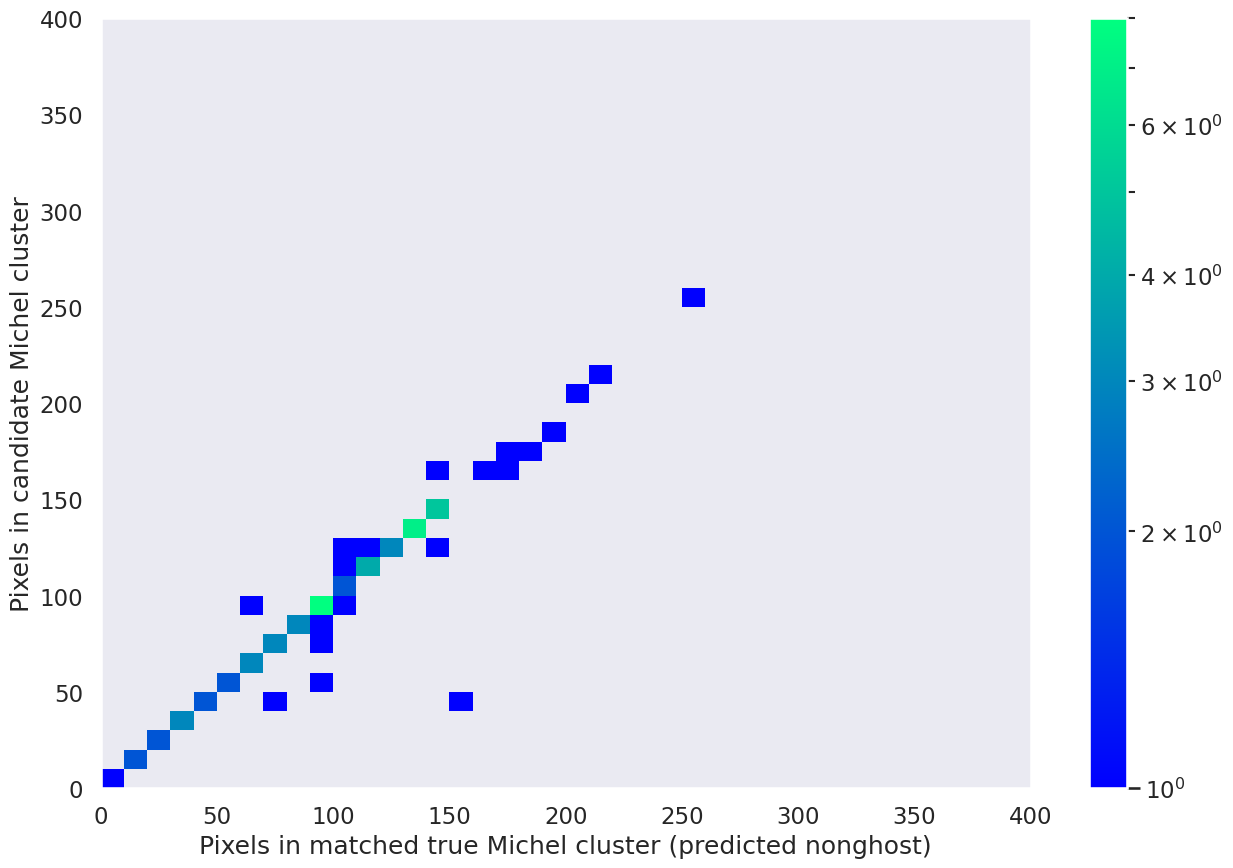

In [58]:
plt.hist2d(michels['true_num_pix'],
          michels['pred_num_pix'],
          bins=[40, 40], range=[[0, 400], [0, 400]], cmap='winter', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('Pixels in matched true Michel cluster (predicted nonghost)')
plt.ylabel('Pixels in candidate Michel cluster')
plt.show()

## Michel spectrum
This is a helper function to plot boxes later:

In [59]:
# Function to plot error boxes
def makeErrorBoxes(ax, xdata,ydata,xerror,yerror,fc='r',ec='None',alpha=0.5):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye in zip(xdata,ydata,xerror.T,yerror.T):
        rect = matplotlib.patches.Rectangle((xc-xe/2.0,yc-ye/2.0),xe,ye)
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = matplotlib.collections.PatchCollection(errorboxes,facecolor=fc,alpha=alpha,edgecolor=ec, label='Primary ionization')

    # Add collection to axes
    ax.add_collection(pc)

In [60]:
def plot_michel_spectrum(michels, mode='num', min_range=0, max_range=250, bins=20):
    assert mode == 'num' or mode == 'sum'

    entries, edges, _ = plt.hist(michels['true_noghost_primary_%s_pix' % mode], bins=bins, range=[min_range, max_range], alpha=0.5, histtype='step')
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    entries3, edges3, _ = plt.hist(michels['true_%s_pix' % mode], bins=bins, range=[min_range, max_range], alpha=0.5, histtype='step')
    bin_centers3 = 0.5 * (edges3[:-1] + edges3[1:])   

    entries2, edges2, _ = plt.hist(michels['pred_%s_pix' % mode], bins=bins, range=[min_range, max_range], alpha=0.5, histtype='step')
    bin_centers2 = 0.5 * (edges2[:-1] + edges2[1:])

    plt.clf()
    #h1 = plt.hist(michels['michel_true_num_voxels'], bins=bins, range=[0, max_range], label='True Michel', alpha=0.5, histtype='step')
    h2 = plt.errorbar(bin_centers2, entries2, yerr=np.sqrt(entries2), fmt='.', label='Predicted candidate Michel electron')

    makeErrorBoxes(plt.gca(), bin_centers,entries,np.ones_like(bin_centers)*max_range/bins,np.sqrt(entries), fc='g')
    makeErrorBoxes(plt.gca(), bin_centers3,entries3,np.ones_like(bin_centers3)*max_range/bins,np.sqrt(entries3), fc='orange')

    pc = matplotlib.patches.Patch(color='green', label='Michel (true non-ghost)', alpha=0.4, linewidth=0.0)
    pc3 = matplotlib.patches.Patch(color='orange', label='Michel (predicted non-ghost)', alpha=0.4, linewidth=0.0)
    handles, labels = plt.gca().get_legend_handles_labels()

    handles = handles+[pc, pc3]
    # if mode == 'num':
    #     handles = handles+[pc, pc3]
    # else:
    #     handles = handles+[pc3]
    plt.legend(handles=handles, labels=labels+['True Michel (true non-ghost mask)', 'True Michel (predicted non-ghost mask)'])

    #plt.legend()
    plt.xlabel('Number of pixels' if mode == 'num' else 'Sum of pixels')
    plt.ylabel('Michel electrons clusters')
    #plt.ylim(0, 200)
    plt.xlim(min_range, max_range)

### Pixel count spectrum

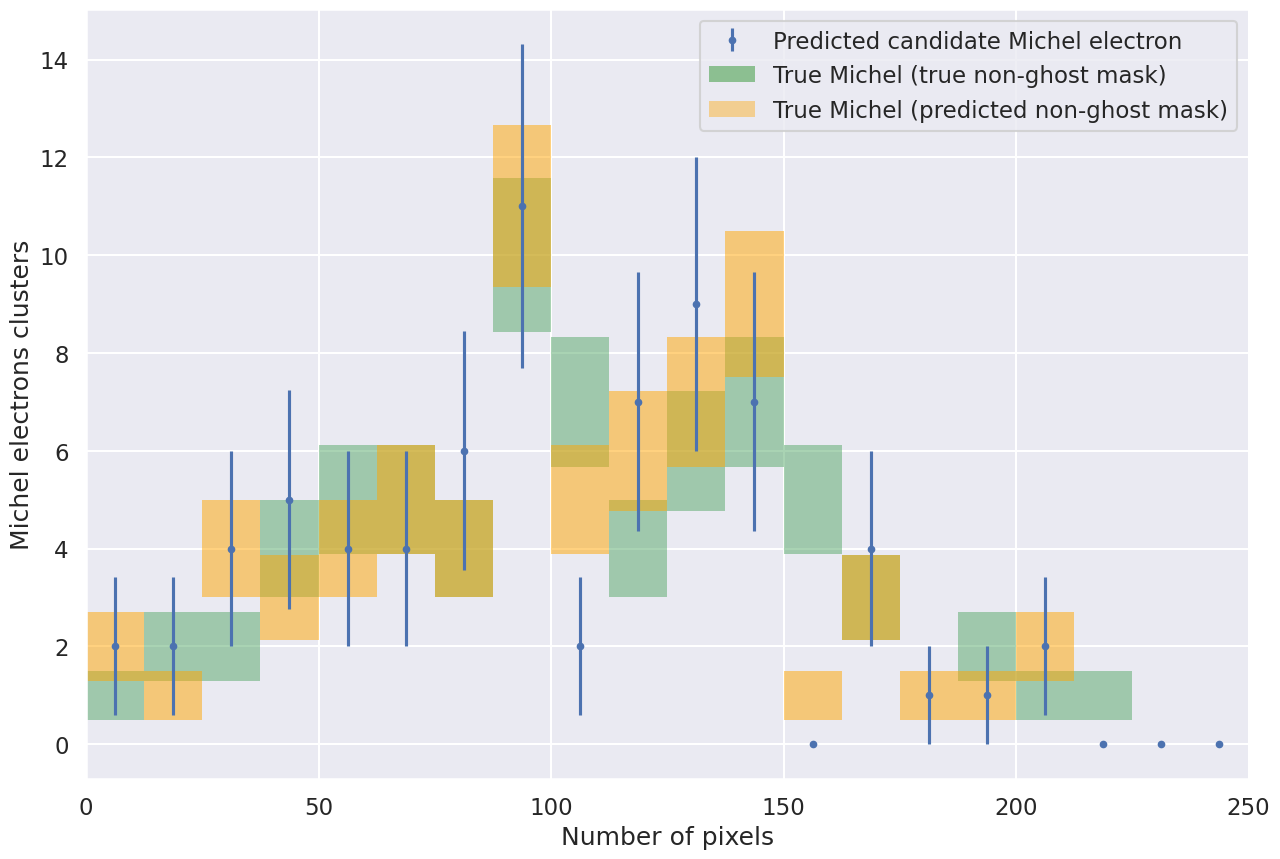

In [61]:
plot_michel_spectrum(michels, mode='num')

### Pixel sum spectrum

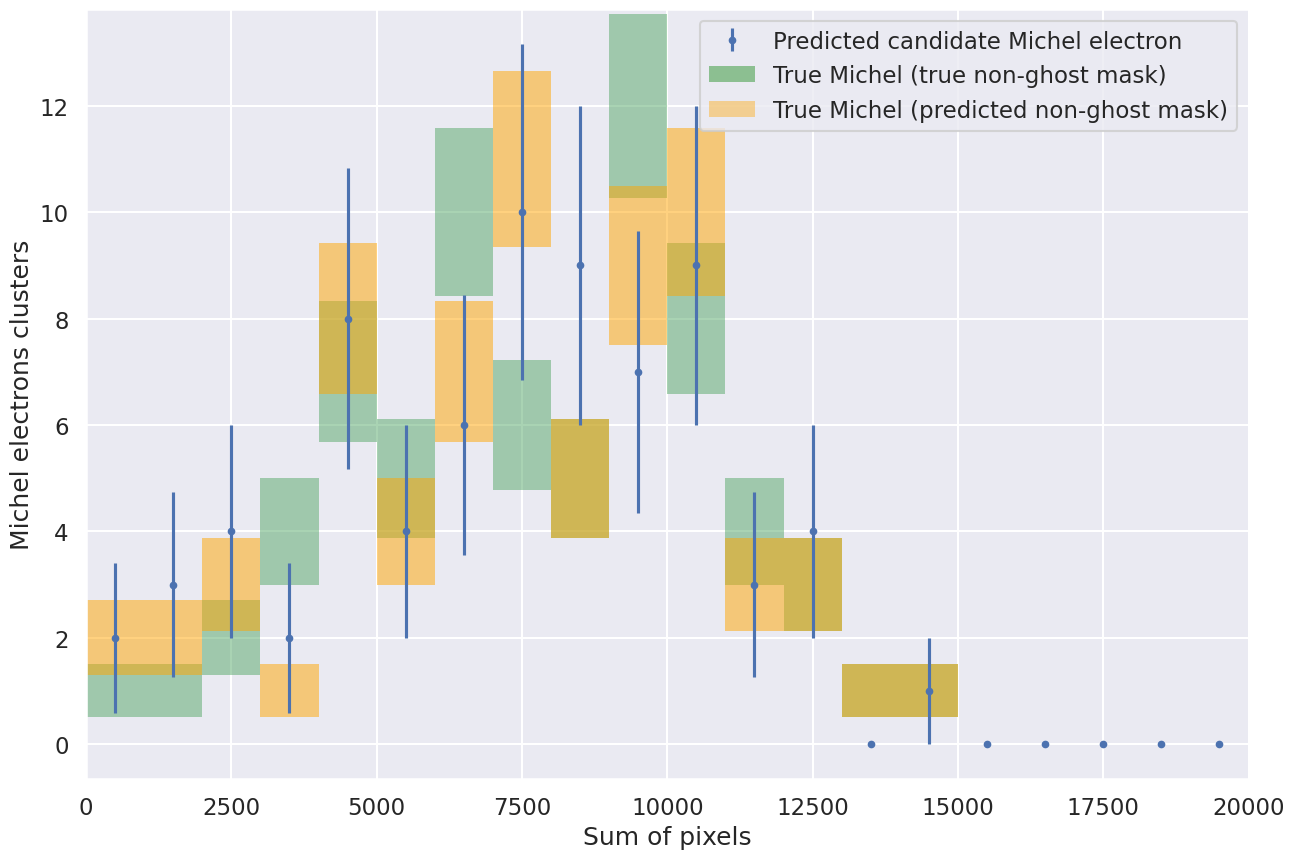

In [62]:
plot_michel_spectrum(michels, mode='sum', max_range=2e4)

## IV. Exercises

- Identify sources of inneficiency:
  - Find which entries have true Michels that are not reconstructed
  - Visualize these entries in an event display
  - Catalogue what is going wrong
- Identify sources of inpurity:
  - Find which entries have reco. Michels that are not matched to a true Michel
  - Visualize these entries in an event display
  - Catalogue what is going wrong
- Do some simple energy calibration:
  - Draw the true particle charge depositions (`truth_particle.truth_depositions`) as a function of the true particle initial energy (`truth_particle.asis.energy_init()`)
  - Fit with a line, find a conversion factor from ADC to MeV
  - Convert pixel charge to MeV, draw the Michel spectrum
- Estimate Michel energy resolution
  - Draw the reco. particle charge depositions (`particle.depositions`) as a function of the match true particle initial energy (`truth_particle.asis.energy_init()`)
  - Bin it in true energy, estimate the std in each bin
- Run more statistics